---
This script enhances the technician routing model by incorporating straw management constraints. Each technician begins with an initial number of straws, must serve a set of assigned farmers, and may visit a central office node for replenishment. The model ensures straw sufficiency at each farmer visit and tracks straw flow across the route. It also integrates MTZ subtour elimination and distinguishes between visiting and serving nodes. The goal remains to minimize total travel distance, subject to operational and logistical constraints.

---

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 54.6 MB/s eta 0:00:00


---
To demonstrate the solution of the bi-objective optimization problem, we use a sample network consisting of 12 nodes (representing the office, technicians, and farmers) interconnected by 20 edges. This model demonstrates technician route planning using Gurobi.

---
This model extends the routing framework by integrating straw logistics. The goal is to minimize the total travel distance for each technician while ensuring the following:

* **Technician starting condition**
  Each technician starts their route at their designated origin node with an initial supply of straws.

* **Route departure from origin**
  Each technician must depart exactly once from their origin node.

* **Return to origin**
  Each technician must return to their origin node at least once, ensuring a closed route.

* **Flow conservation**
  For each node in the route (excluding the origin), the number of incoming paths must equal the number of outgoing paths.

* **Farmer service enforcement**
  Each assigned farmer must be visited and served exactly once by their designated technician.

* **Straw availability constraint**
  A technician must have at least one straw available before serving a farmer.

* **Office refill requirement**
  Technicians are required to visit the office node at least once to replenish their straw supply, especially when their initial stock is insufficient.

* **Straw balance tracking**
  The straw count is updated along each arc: it decreases when serving a farmer and increases when visiting the office. This ensures technicians never run out of straws mid-route.

* **No subtours allowed**
  To prevent disconnected loops, the model uses Miller–Tucker–Zemlin (MTZ) constraints to ensure a valid, continuous path for each technician.

  ---

  This sample assignment is derived from the results of the previous resource allocation model. In this case, Technician 4 is assigned to farmers 0, 2, 6, and 7, while Technician 8 is assigned to farmers 3, 5, 9, 10, and 11. The technicians begin with 2 and 1 straws, respectively. They may replenish straws by visiting the office located at node 1, where Technician 4 can refill 2 straws per visit and Technician 8 can refill 4.

  ---


In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB


distance = np.array([
    [0, 15, 0, 0, 24, 0, 18, 0, 0, 0, 0, 0],
    [15, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 22, 0, 18, 16, 0, 0, 0, 20, 0, 0, 0],
    [0, 0, 18, 0, 0, 12, 0, 0, 0, 0, 0, 0],
    [24, 0, 16, 0, 0, 0, 25, 12, 24, 0, 0, 0],
    [0, 0, 0, 12, 0, 0, 0, 0, 12, 0, 0, 22],
    [18, 0, 0, 0, 25, 0, 0, 15, 0, 22, 0, 0],
    [0, 0, 0, 0, 12, 0, 15, 0, 30, 0, 25, 0],
    [0, 0, 20, 0, 24, 12, 0, 30, 0, 0, 19, 19],
    [0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 19, 0],
    [0, 0, 0, 0, 0, 0, 0, 25, 19, 19, 0, 21],
    [0, 0, 0, 0, 0, 22, 0, 0, 19, 0, 21, 0]
])


farmers = [0, 2, 3, 5, 6, 7, 9, 10, 11]
technicians = [4, 8]
assigned_farmers = {
    4: [0, 2, 6, 7],
    8: [3, 5, 9, 10, 11]
}
initial_straws = {4: 2, 8: 1}
refill_amount = {4: 2, 8: 4}
office_node = 1
offices = [1]

nodes = list(range(len(distance)))
big_M = 1000

model = gp.Model("RoutingWithStraws")
model.Params.OutputFlag = 0

# VARIABLES
x = model.addVars(
    [(i, j, t) for t in technicians for i in nodes for j in nodes
     if i != j and distance[i][j] > 0],
    vtype=GRB.BINARY, name="x"
)
s = model.addVars(nodes, technicians, lb=-1000, ub=1000, vtype=GRB.INTEGER, name="s")
serve = model.addVars(nodes, technicians, vtype=GRB.BINARY, name="serve")
visit = model.addVars(nodes, technicians, vtype=GRB.BINARY, name="visit")
u = model.addVars(nodes, technicians, lb=0, ub=len(nodes), vtype=GRB.CONTINUOUS, name="u")  # 🔁 Added


# OBJECTIVE FUNCTION
model.setObjective(gp.quicksum(x[i, j, t] * distance[i][j] for (i, j, t) in x), GRB.MINIMIZE)

# CONSTRAINTS
for t in technicians:
    origin = t
    refill = refill_amount[t]

    model.addConstr(s[origin, t] == initial_straws[t])
    model.addConstr(gp.quicksum(x[origin, j, t] for j in nodes if (origin, j, t) in x) == 1)
    model.addConstr(gp.quicksum(x[i, origin, t] for i in nodes if (i, origin, t) in x) >= 1)

    for j in nodes:
        if j != origin:
            model.addConstr(
                gp.quicksum(x[i, j, t] for i in nodes if (i, j, t) in x) ==
                gp.quicksum(x[j, k, t] for k in nodes if (j, k, t) in x)
            )

    for f in assigned_farmers[t]:
        model.addConstr(serve[f, t] == 1)
        model.addConstr(serve[f, t] <= visit[f, t])
        model.addConstr(gp.quicksum(x[i, f, t] for i in nodes if (i, f, t) in x) == visit[f, t])
        model.addConstr(gp.quicksum(x[f, j, t] for j in nodes if (f, j, t) in x) == visit[f, t])

    model.addConstr(gp.quicksum(x[i, office_node, t] for i in nodes if (i, office_node, t) in x) >= 1)

    for i in nodes:
        for j in nodes:
            if i != j and (i, j, t) in x:
                model.addConstr(
                    s[j, t] >= s[i, t] - serve[j, t] + refill * (j == office_node) - big_M * (1 - x[i, j, t])
                )

    for j in assigned_farmers[t]:
        model.addConstr(s[j, t] >= serve[j, t])

    for j in nodes:
        if j not in assigned_farmers[t]:
            model.addConstr(serve[j, t] == 0)

    for j in nodes:
        if j != t:
            model.addConstr(
                visit[j, t] == gp.quicksum(x[i, j, t] for i in nodes if (i, j, t) in x)
            )

    for i in nodes:
        for j in nodes:
            if i != j and i != t and j != t and (i, j, t) in x:
                model.addConstr(u[i, t] - u[j, t] + len(nodes) * x[i, j, t] <= len(nodes) - 1)


model.optimize()

status_dict = {
    GRB.OPTIMAL: "OPTIMAL",
    GRB.INFEASIBLE: "INFEASIBLE",
    GRB.UNBOUNDED: "UNBOUNDED",
    GRB.INF_OR_UNBD: "INFEASIBLE OR UNBOUNDED",
    GRB.TIME_LIMIT: "TIME LIMIT REACHED",
    GRB.INTERRUPTED: "INTERRUPTED",
    GRB.SUBOPTIMAL: "SUBOPTIMAL"
}
print(f"Optimization Status: {status_dict.get(model.Status, 'UNKNOWN')} ({model.Status})")

if model.Status == GRB.INFEASIBLE:
    print("\nModel is INFEASIBLE. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to model.ilp")


for t in technicians:
    print("\n" + "=" * 80)
    print(f"Technician {t} Route:")
    print("-" * 80)
    print(f"{'Step':<5} {'Node':<6} {'Type':<30} {'Straws':<8} {'Step Dist':<10} {'Cumulative Dist'}")
    print("-" * 80)

    route_map = {i: j for (i, j, tech) in x if tech == t and x[i, j, t].X > 0.5}
    visited_nodes = set()
    current = t
    cumulative_dist = 0
    step = 0

    while current in route_map and current not in visited_nodes:
        next_node = route_map[current]
        dist = distance[current][next_node]
        cumulative_dist += dist
        visited_nodes.add(current)

        if current == office_node:
            node_type = f"🏢 Office (+{refill_amount[t]})"
        elif serve[current, t].X > 0.5:
            node_type = "🐃 Farmer ✅ Served"
        elif current == t:
            node_type = "🟢 Technician Start"
        else:
            node_type = "➡️ Passed Through"

        print(f"{step:<5} {current:<6} {node_type:<30} {int(s[current, t].X):<8} {dist:<10} {cumulative_dist - dist}")
        step += 1
        current = next_node

    if current not in visited_nodes:
        visited_nodes.add(current)
        if current == office_node:
            node_type = f"🏢 Office (+{refill_amount[t]})"
        elif serve[current, t].X > 0.5:
            node_type = "🐃 Farmer ✅ Served"
        elif current == t:
            node_type = "🟢 Technician Start"
        else:
            node_type = "➡️ Passed Through"
        print(f"{step:<5} {current:<6} {node_type:<30} {int(s[current, t].X):<8} {0:<10} {cumulative_dist}")

    print("-" * 80)
    total = sum(x[i, j, t].X * distance[i][j] for (i, j, tt) in x if tt == t)
    print(f"Total Distance Traveled by Technician {t}: {total:.2f} units")
print("\n" + "=" * 80)

Optimization Status: OPTIMAL (2)

Technician 4 Route:
--------------------------------------------------------------------------------
Step  Node   Type                           Straws   Step Dist  Cumulative Dist
--------------------------------------------------------------------------------
0     4      🟢 Technician Start             2        16         0
1     2      🐃 Farmer ✅ Served              1        22         16
2     1      🏢 Office (+2)                  3        15         38
3     0      🐃 Farmer ✅ Served              2        18         53
4     6      🐃 Farmer ✅ Served              1        15         71
5     7      🐃 Farmer ✅ Served              1        12         86
--------------------------------------------------------------------------------
Total Distance Traveled by Technician 4: 98.00 units

Technician 8 Route:
--------------------------------------------------------------------------------
Step  Node   Type                           Straws   Step Dist  Cum

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_routes_with_distances_and_straws(distance_matrix, solution_edges, technicians, assignments, office_node, straw_levels):
    G = nx.DiGraph()
    n = len(distance_matrix)
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(n):
            if distance_matrix[i][j] != 0:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(14, 10))

    # --- DRAW BASE GRAPH (GRAY) ---
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in range(n)}, font_size=9)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1.5, arrows=False, alpha=0.5)

    # --- DISTANCE LABELS on GRAY EDGES ---
    edge_labels = {(i, j): f"d={G[i][j]['weight']}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray', font_size=8, rotate=False)

    # --- FIXED COLOR LIST ---
    colors = ['red', 'teal',  'orange','green', 'purple', 'brown', 'cyan', 'magenta', 'lime', 'teal']
    base_offsets = [0.12, -0.12, 0.2, -0.2, 0.3, -0.3, 0.18, -0.18]
    offset_map = {idx: base_offsets[idx % len(base_offsets)] for idx in range(len(technicians))}

    for idx, t in enumerate(technicians):
        tech_edges = [(i, j) for (i, j, tt) in solution_edges if tt == t]
        color = colors[idx % len(colors)]
        offset = offset_map.get(idx, 0.1 * (-1) ** idx)

        # Draw technician arcs
        nx.draw_networkx_edges(
            G, pos,
            edgelist=tech_edges,
            edge_color=color,
            width=3,
            arrows=True,
            arrowsize=20,
            connectionstyle=f"arc3,rad={offset}"
        )

        for (i, j) in tech_edges:
            straw = straw_levels.get((i, t), None)
            if straw is not None:
                x1, y1 = pos[i]
                x2, y2 = pos[j]
                mx, my = (x1 + x2) / 2, (y1 + y2) / 2

                dx, dy = x2 - x1, y2 - y1
                norm = np.sqrt(dx**2 + dy**2)
                if norm == 0:
                    continue
                px, py = -dy / norm, dx / norm
                label_x = mx + offset * px * 0.5
                label_y = my + offset * py * 0.5

                plt.text(label_x, label_y, f"s={straw:.1f}",
                         fontsize=9, fontweight='bold',
                         color='white', ha='left', va='bottom',
                         bbox=dict(boxstyle='round,pad=0.2', fc=color, ec='none', alpha=1.0))

        # Technician start node
        nx.draw_networkx_nodes(G, pos, nodelist=[t], node_color=color, node_size=800, node_shape='*', label=f'Tech {t}')

        # Assigned farmers
        nx.draw_networkx_nodes(G, pos, nodelist=assignments[t],
                               node_color=color, node_size=500, node_shape='s')

    # Office node
    nx.draw_networkx_nodes(G, pos, nodelist=[office_node], node_color='gold',
                           node_shape='^', node_size=700, label='Office')

    plt.title("Technician Routes")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

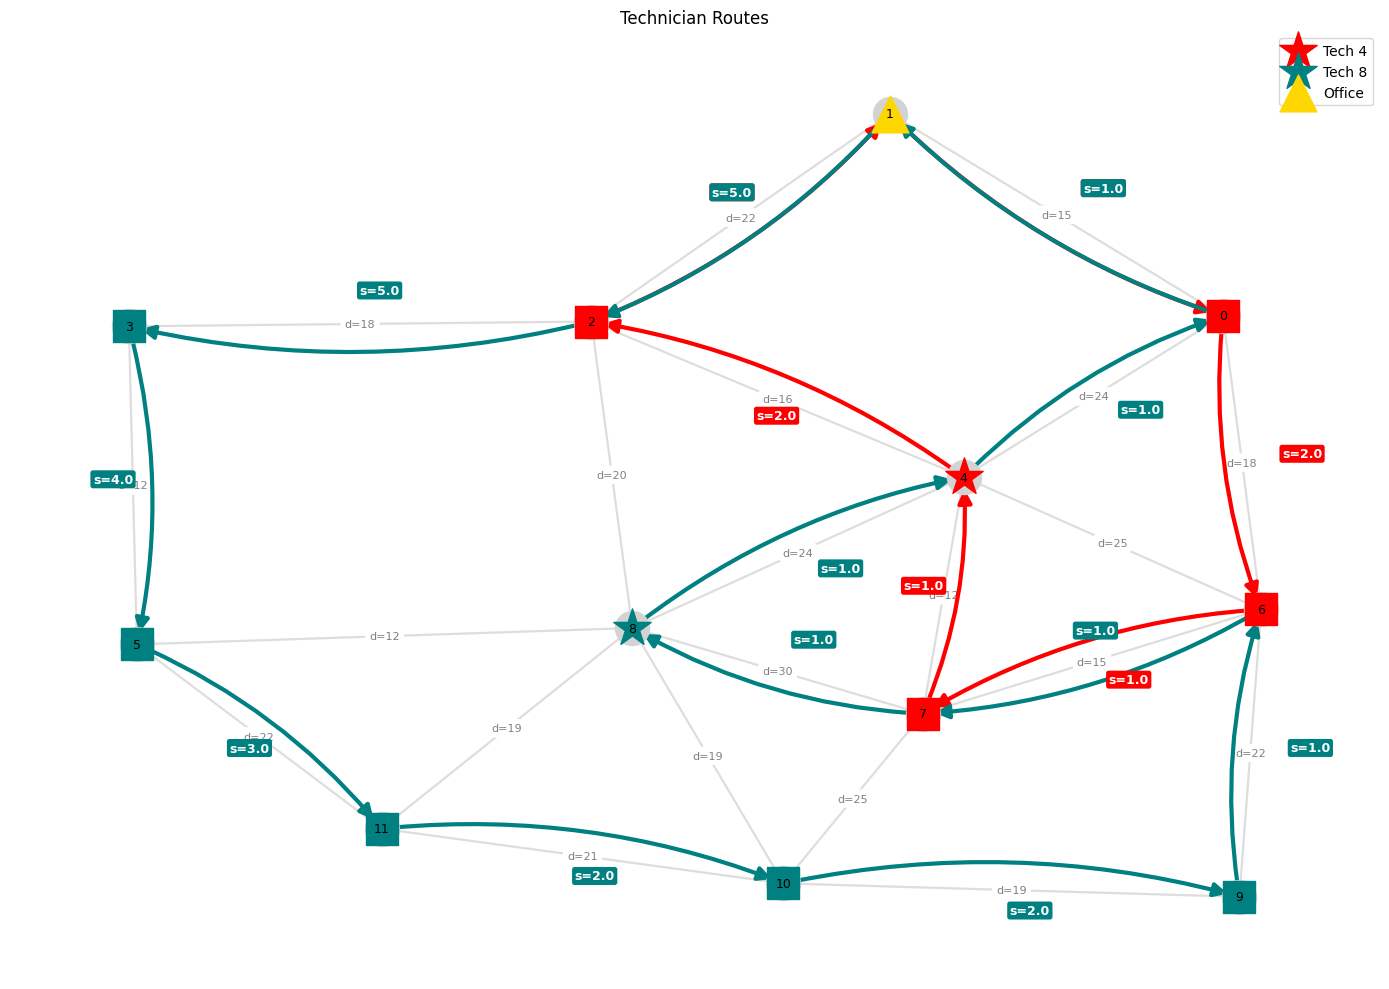

In [ ]:
# Edges used in the solution
solution_edges = [(i, j, t) for (i, j, t) in x.keys() if x[i, j, t].X > 0.5]

# Straw levels after visiting node i by technician t
straw_levels = {(i, t): s[i, t].X for i in nodes for t in technicians if (i, t) in s}

plot_routes_with_distances_and_straws(
    distance_matrix=distance,
    solution_edges=solution_edges,
    technicians=technicians,
    assignments=assigned_farmers,
    office_node=office_node,
    straw_levels=straw_levels
)


---

This is another sample assignment is derived from the results of the previous resource allocation model. In this setup:

* **Technician 0** is assigned to farmers **6 and 9**,
* **Technician 4** is assigned to farmers **1, 2, and 7**,
* **Technician 5** is assigned to farmers **3, 10, and 11**.

Each technician starts with **1 straw** and may replenish at the **office located at node 8**, where **Technician 0** can refill **1 straw per visit**, while **Technicians 4 and 5** can each refill **2 straws per visit**.

---

In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB


distance = np.array([
    [0, 15, 0, 0, 24, 0, 18, 0, 0, 0, 0, 0],
    [15, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 22, 0, 18, 16, 0, 0, 0, 20, 0, 0, 0],
    [0, 0, 18, 0, 0, 12, 0, 0, 0, 0, 0, 0],
    [24, 0, 16, 0, 0, 0, 25, 12, 24, 0, 0, 0],
    [0, 0, 0, 12, 0, 0, 0, 0, 12, 0, 0, 22],
    [18, 0, 0, 0, 25, 0, 0, 15, 0, 22, 0, 0],
    [0, 0, 0, 0, 12, 0, 15, 0, 30, 0, 25, 0],
    [0, 0, 20, 0, 24, 12, 0, 30, 0, 0, 19, 19],
    [0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 19, 0],
    [0, 0, 0, 0, 0, 0, 0, 25, 19, 19, 0, 21],
    [0, 0, 0, 0, 0, 22, 0, 0, 19, 0, 21, 0]
])


farmers = [1, 2, 3, 5, 6, 7, 9, 10, 11]
technicians = [0, 4, 5]
assigned_farmers = {
    0: [6, 9],
    4: [1, 2, 7],
    5: [3, 10, 11]
}

initial_straws = {0: 1, 4: 1, 5: 1}
refill_amount = {0: 1, 4: 2, 5: 2}
office_node = 8
offices = [8]

nodes = list(range(len(distance)))
big_M = 1000

model = gp.Model("RoutingWithStraws")
model.Params.OutputFlag = 0


# VARIABLES
x = model.addVars(
    [(i, j, t) for t in technicians for i in nodes for j in nodes
     if i != j and distance[i][j] > 0],
    vtype=GRB.BINARY, name="x"
)
s = model.addVars(nodes, technicians, lb=-1000, ub=1000, vtype=GRB.INTEGER, name="s")
serve = model.addVars(nodes, technicians, vtype=GRB.BINARY, name="serve")
visit = model.addVars(nodes, technicians, vtype=GRB.BINARY, name="visit")
u = model.addVars(nodes, technicians, lb=0, ub=len(nodes), vtype=GRB.CONTINUOUS, name="u")  # 🔁 Added


# OBJECTIVE FUNCTION
model.setObjective(gp.quicksum(x[i, j, t] * distance[i][j] for (i, j, t) in x), GRB.MINIMIZE)


# CONSTRAINTS
for t in technicians:
    origin = t
    refill = refill_amount[t]

    model.addConstr(s[origin, t] == initial_straws[t])
    model.addConstr(gp.quicksum(x[origin, j, t] for j in nodes if (origin, j, t) in x) == 1)
    model.addConstr(gp.quicksum(x[i, origin, t] for i in nodes if (i, origin, t) in x) >= 1)

    for j in nodes:
        if j != origin:
            model.addConstr(
                gp.quicksum(x[i, j, t] for i in nodes if (i, j, t) in x) ==
                gp.quicksum(x[j, k, t] for k in nodes if (j, k, t) in x)
            )

    for f in assigned_farmers[t]:
        model.addConstr(serve[f, t] == 1)
        model.addConstr(serve[f, t] <= visit[f, t])
        model.addConstr(gp.quicksum(x[i, f, t] for i in nodes if (i, f, t) in x) == visit[f, t])
        model.addConstr(gp.quicksum(x[f, j, t] for j in nodes if (f, j, t) in x) == visit[f, t])

    model.addConstr(gp.quicksum(x[i, office_node, t] for i in nodes if (i, office_node, t) in x) >= 1)

    for i in nodes:
        for j in nodes:
            if i != j and (i, j, t) in x:
                model.addConstr(
                    s[j, t] >= s[i, t] - serve[j, t] + refill * (j == office_node) - big_M * (1 - x[i, j, t])
                )

    for j in assigned_farmers[t]:
        model.addConstr(s[j, t] >= serve[j, t])

    for j in nodes:
        if j not in assigned_farmers[t]:
            model.addConstr(serve[j, t] == 0)

    for j in nodes:
        if j != t:
            model.addConstr(
                visit[j, t] == gp.quicksum(x[i, j, t] for i in nodes if (i, j, t) in x)
            )

    for i in nodes:
        for j in nodes:
            if i != j and i != t and j != t and (i, j, t) in x:
                model.addConstr(u[i, t] - u[j, t] + len(nodes) * x[i, j, t] <= len(nodes) - 1)


model.optimize()

status_dict = {
    GRB.OPTIMAL: "OPTIMAL",
    GRB.INFEASIBLE: "INFEASIBLE",
    GRB.UNBOUNDED: "UNBOUNDED",
    GRB.INF_OR_UNBD: "INFEASIBLE OR UNBOUNDED",
    GRB.TIME_LIMIT: "TIME LIMIT REACHED",
    GRB.INTERRUPTED: "INTERRUPTED",
    GRB.SUBOPTIMAL: "SUBOPTIMAL"
}
print(f"Optimization Status: {status_dict.get(model.Status, 'UNKNOWN')} ({model.Status})")

if model.Status == GRB.INFEASIBLE:
    print("\n Model is INFEASIBLE. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    print(" IIS written to model.ilp")


for t in technicians:
    print("\n" + "=" * 80)
    print(f"Technician {t} Route:")
    print("-" * 80)
    print(f"{'Step':<5} {'Node':<6} {'Type':<30} {'Straws':<8} {'Step Dist':<10} {'Cumulative Dist'}")
    print("-" * 80)

    route_map = {i: j for (i, j, tech) in x if tech == t and x[i, j, t].X > 0.5}
    visited_nodes = set()
    current = t
    cumulative_dist = 0
    step = 0

    while current in route_map and current not in visited_nodes:
        next_node = route_map[current]
        dist = distance[current][next_node]
        cumulative_dist += dist
        visited_nodes.add(current)

        if current == office_node:
            node_type = f"🏢 Office (+{refill_amount[t]})"
        elif serve[current, t].X > 0.5:
            node_type = "🐃 Farmer ✅ Served"
        elif current == t:
            node_type = "🟢 Technician Start"
        else:
            node_type = "➡️ Passed Through"

        print(f"{step:<5} {current:<6} {node_type:<30} {int(s[current, t].X):<8} {dist:<10} {cumulative_dist - dist}")
        step += 1
        current = next_node

    if current not in visited_nodes:
        visited_nodes.add(current)
        if current == office_node:
            node_type = f"🏢 Office (+{refill_amount[t]})"
        elif serve[current, t].X > 0.5:
            node_type = "🐃 Farmer ✅ Served"
        elif current == t:
            node_type = "🟢 Technician Start"
        else:
            node_type = "➡️ Passed Through"
        print(f"{step:<5} {current:<6} {node_type:<30} {int(s[current, t].X):<8} {0:<10} {cumulative_dist}")

    print("-" * 80)
    total = sum(x[i, j, t].X * distance[i][j] for (i, j, tt) in x if tt == t)
    print(f"Total Distance Traveled by Technician {t}: {total:.2f} units")
print("\n" + "=" * 80)

Optimization Status: OPTIMAL (2)

Technician 0 Route:
--------------------------------------------------------------------------------
Step  Node   Type                           Straws   Step Dist  Cumulative Dist
--------------------------------------------------------------------------------
0     0      🟢 Technician Start             1        24         0
1     4      ➡️ Passed Through              1        24         24
2     8      🏢 Office (+1)                  2        19         48
3     10     ➡️ Passed Through              2        19         67
4     9      🐃 Farmer ✅ Served              1        22         86
5     6      🐃 Farmer ✅ Served              1        18         108
--------------------------------------------------------------------------------
Total Distance Traveled by Technician 0: 126.00 units

Technician 4 Route:
--------------------------------------------------------------------------------
Step  Node   Type                           Straws   Step Dist  C

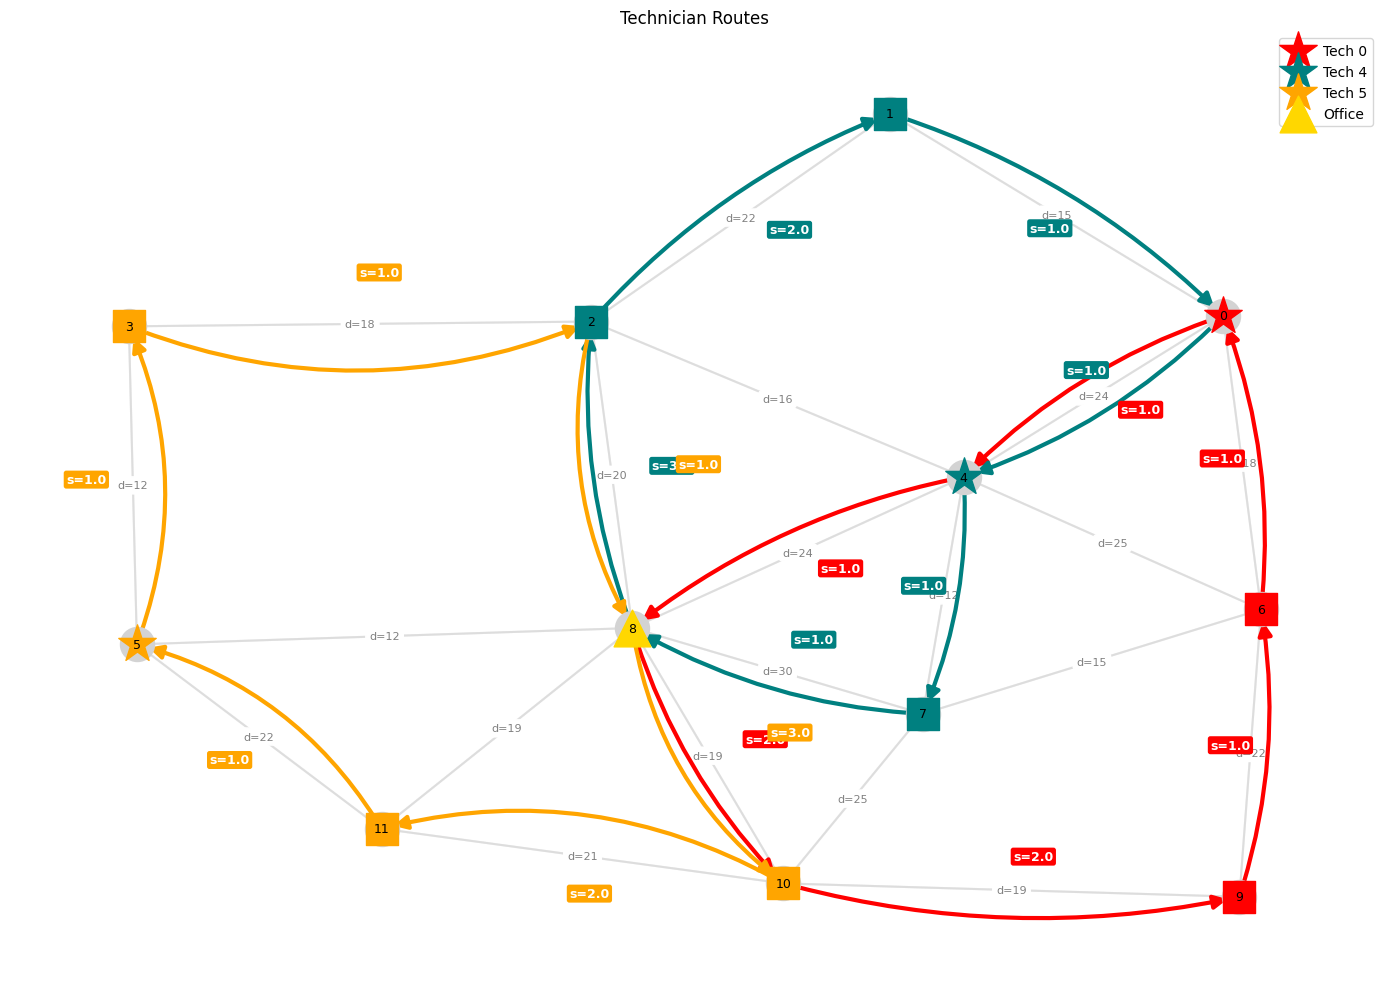

In [ ]:
# Edges used in the solution
solution_edges = [(i, j, t) for (i, j, t) in x.keys() if x[i, j, t].X > 0.5]

# Straw levels after visiting node i by technician t
straw_levels = {(i, t): s[i, t].X for i in nodes for t in technicians if (i, t) in s}

plot_routes_with_distances_and_straws(
    distance_matrix=distance,
    solution_edges=solution_edges,
    technicians=technicians,
    assignments=assigned_farmers,
    office_node=office_node,
    straw_levels=straw_levels
)